The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6


# Deep Factorization Machines

Learning effective feature combinations is critical to the success of click-through rate prediction task. Factorization machines model feature interactions in a linear paradigm (e.g., bilinear interactions). This is often insufficient for real-world data where inherent feature crossing structures are usually very complex and nonlinear. What's worse, second-order feature interactions are generally used in factorization machines in practice. Modeling higher degrees of feature combinations with factorization machines is possible theoretically but it is usually not adopted due to numerical instability and high computational complexity.

One effective solution is using deep neural networks. Deep neural networks are powerful in feature representation learning and have the potential to learn sophisticated feature interactions. As such, it is natural to integrate deep neural networks to factorization machines. Adding nonlinear transformation layers to factorization machines gives it the capability to model both low-order feature combinations and high-order feature combinations. Moreover, non-linear inherent structures from inputs can also be captured with deep neural networks. In this section, we will introduce a representative model named deep factorization machines (DeepFM) :cite:`Guo.Tang.Ye.ea.2017` which combine FM and deep neural networks. 


## Model Architectures 

DeepFM consists of an FM component and a deep component which are integrated in a parallel structure. The FM component is the same as the 2-way factorization machines which is used to model the low-order feature interactions. The deep component is a multi-layered perceptron that is used to capture high-order feature interactions and nonlinearities. These two components share the same inputs/embeddings and their outputs are summed up as the final prediction. It is worth pointing out that the spirit of DeepFM resembles that of the Wide \& Deep architecture which can capture both memorization and generalization. The advantages of DeepFM over the Wide \& Deep model is that it reduces the effort of hand-crafted feature engineering by identifying feature combinations automatically. 

We omit the description of the FM component for brevity and denote the output as $\hat{y}^{(FM)}$. Readers are referred to the last section for more details. Let $\mathbf{e}_i \in \mathbb{R}^{k}$ denote the latent feature vector of the $i^\mathrm{th}$ field.  The input of the deep component is the concatenation of the dense embeddings of all fields that are looked up with the sparse categorical feature input, denoted as:

$$
\mathbf{z}^{(0)}  = [\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_f],
$$

where $f$ is the number of fields.  It is then fed into the following neural network:

$$
\mathbf{z}^{(l)}  = \alpha(\mathbf{W}^{(l)}\mathbf{z}^{(l-1)} + \mathbf{b}^{(l)}),
$$

where $\alpha$ is the activation function.  $\mathbf{W}_{l}$ and $\mathbf{b}_{l}$ are the weight and bias at the $l^\mathrm{th}$ layer. Let $y_{DNN}$ denote the output of the prediction. The ultimate prediction of DeepFM is the summation of the outputs from both FM and DNN. So we have: 

$$
\hat{y} = \sigma(\hat{y}^{(FM)} + \hat{y}^{(DNN)}),
$$

where $\sigma$ is the sigmoid function. The architecture of DeepFM is illustrated below.
![Illustration of the DeepFM model](../img/rec-deepfm.svg)

It is worth noting that DeepFM is not the only way to combine deep neural networks with FM. We can also add nonlinear layers over the feature interactions :cite:`He.Chua.2017`.

In [1]:
import d2l
from mxnet import init, gluon, np, npx
from mxnet.gluon import nn
import sys
npx.set_np()

## Implemenation of DeepFM
The implementation of DeepFM is similar to that of FM. We keep the FM part unchanged and use an MLP block with `relu` as the activation function. Dropout is also used to regularize the model. The number of neurons of the MLP can be adjusted with the `mlp_dims` hyper-parameter.

In [2]:
class DeepFM(nn.Block):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = nn.Sequential()
        for dim in mlp_dims:
            self.mlp.add(nn.Dense(dim, 'relu', True, in_units=input_dim))
            self.mlp.add(nn.Dropout(rate=drop_rate))
            input_dim = dim
        self.mlp.add(nn.Dense(in_units=input_dim, units=1))
        
    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = np.sum(embed_x, axis=1) ** 2
        sum_of_square = np.sum(embed_x ** 2, axis=1)
        inputs = np.reshape(embed_x, (-1, self.embed_output_dim))
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = npx.sigmoid(x)
        return x

## Training and Evaluating the Model
The data loading process is the same as that of FM. We set the MLP component of DeepFM to a three-layered dense network with the a pyramid structure (30-20-10). All other hyper-parameters remain the same as FM.

loss 0.509, train acc 0.761, test acc 0.751
121472.2 examples/sec on [gpu(0), gpu(1)]


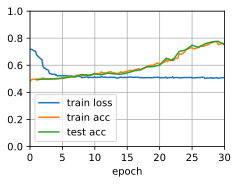

In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(data_dir + "train.csv")
test_data = d2l.CTRDataset(data_dir + "test.csv",
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
field_dims = train_data.field_dims
num_workers = 0 if sys.platform.startswith("win") else 4
train_iter = gluon.data.DataLoader(train_data, shuffle=True,
                                   last_batch="rollover",
                                   batch_size=batch_size,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(test_data, shuffle=False,
                                  last_batch="rollover",
                                  batch_size=batch_size,
                                  num_workers=num_workers)
ctx = d2l.try_all_gpus()
net = DeepFM(field_dims, num_factors=10, mlp_dims=[30, 20, 10])
net.initialize(init.Xavier(), ctx=ctx)
lr, num_epochs, optimizer = 0.01, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

Compared with FM, DeepFM converges faster and achieves better performance.

## Summary 

* Integrating neural networks to FM enables it to model complex and high-order interactions. 
* DeepFM outperforms the original FM on the advertising dataset.

## Exercise
* Vary the structure of the MLP to check its impact on model performance.
* Change the dataset to Criteo and compare it with the original FM model.

## [Discussions](https://discuss.mxnet.io/t/5168)

![](http://d2l.ai/_images/qr_deepfm.svg)